In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

mse = tf.keras.losses.mean_squared_error
keras = tf.keras

# Predict timeseries using RNNs

This notebook builds on examples from [Aurélien Geron](https://github.com/ageron)'s 'HOML' [book](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=pd_lpo_14_t_0/142-2845596-3967762?_encoding=UTF8&pd_rd_i=1492032646&pd_rd_r=d2dd3765-3adb-4d08-a5ea-997a3bdea8b6&pd_rd_w=RDlx0&pd_rd_wg=htxHU&pf_rd_p=7b36d496-f366-4631-94d3-61b87b52511b&pf_rd_r=K65X3985TYC0AV665787&psc=1&refRID=K65X3985TYC0AV665787) and my own experiences.

## Predict one step ahead using artificial data

### Generate and visualize the data

In [2]:
# Generate the data
def get_data(batch_size, n_steps):
    
    freq1, freq2     = np.random.rand(2, batch_size, 1)
    offset1, offset2 = np.random.rand(2, batch_size, 1)
    
    time = np.linspace(0, 1, n_steps)
    
    mixture  = .6 * np.sin((time - offset1) * (freq1 * 10 + 10))
    mixture += .3 * np.sin((time - offset2) * (freq2 * 10 + 10))
    mixture += .15 * (np.random.rand(batch_size, n_steps) - .5)
    
    return mixture[..., np.newaxis]

In [3]:
# Generate the data
n_steps = 50
data_1 = get_data(10000, n_steps + 1)      # Add one to get the y_true value

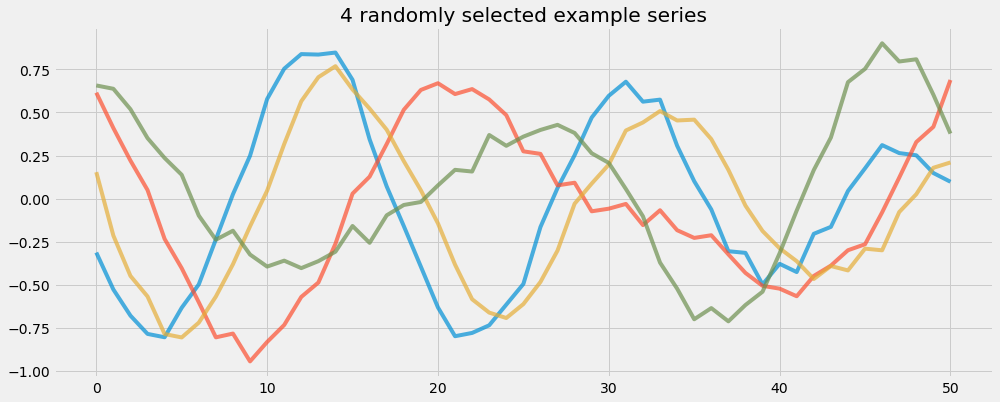

In [4]:
# Visualize the data
n_samples = 4

plt.figure(figsize = (15, 6))
for d in data_1[np.random.choice(data_1.shape[0], n_samples, replace = False), :]:
    plt.plot(d, alpha = .7)
plt.title(f'{n_samples} randomly selected example series')
plt.show()

### Create a dataset

In [5]:
# Prepare data
X_train, y_train = data_1[:7500, :n_steps], data_1[:7500, -1]
X_val, y_val     = data_1[7500:9000, :n_steps], data_1[7500:9000, -1]
X_test, y_test   = data_1[9000:, :n_steps], data_1[9000:, -1]

### Create a baseline model

In [6]:
lin_reg = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [50, 1]),    # Squeeze the empty dimesion
    keras.layers.Dense(1)
])

In [7]:
lin_reg.compile(optimizer = 'adam', 
                loss      = 'mean_squared_error', 
                metrics   = ['mean_squared_error'])

In [8]:
lin_reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [9]:
lin_reg.fit(X_train, y_train, 
            epochs  = 30, 
            verbose = 1,
            validation_data = (X_val, y_val))

Train on 7500 samples, validate on 1500 samples
Epoch 1/30
7500/7500 [==============================] - 1s 104us/sample - loss: 0.1632 - mean_squared_error: 0.1632 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 2/30
7500/7500 [==============================] - 0s 39us/sample - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 3/30
7500/7500 [==============================] - 0s 41us/sample - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 4/30
7500/7500 [==============================] - 0s 43us/sample - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 5/30
7500/7500 [==============================] - 0s 38us/sample - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 6/30
7500/7500 [==============================] - 0s 38us/sample - loss: 0.0080 - mean_squared_error: 0.0080 -

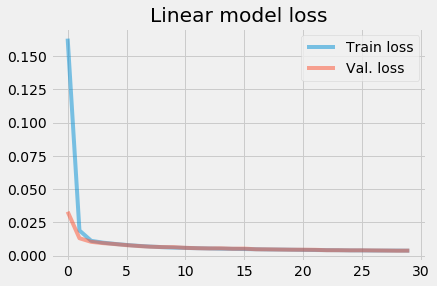

In [10]:
plt.plot(lin_reg.history.history['loss'], label = 'Train loss', alpha = .5)
plt.plot(lin_reg.history.history['val_loss'], label = 'Val. loss', alpha = .5)
plt.title('Linear model loss')
plt.legend()
plt.show()

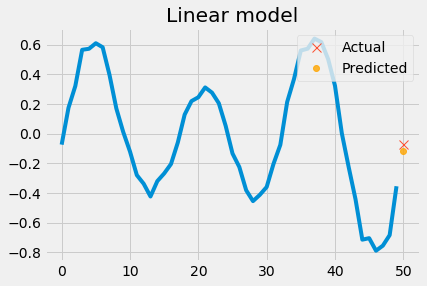

In [11]:
# Visualize the prediction
obs = 10
plt.plot(X_test[obs])
plt.plot(50, y_test[obs], 'x', markersize = 9, lw = 3, label = 'Actual')
plt.plot(50, lin_reg.predict(X_test[obs:obs + 1])[0][0], 'o', alpha = .8, color = 'orange', label = 'Predicted')
plt.legend(loc = 'upper right')
plt.title('Linear model')
plt.show()

In [12]:
# Evaluate
lin_preds = lin_reg.predict(X_test)
mse(lin_preds.squeeze(), y_test.squeeze()).numpy()

0.0037099269717321627

Linear model benchmark on 30 epochs on test: $MSE = 0.0037$

### Create an RNN

In [13]:
model_1 = keras.models.Sequential([
    keras.layers.SimpleRNN(24, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(24),
    keras.layers.Dense(1)
])

In [14]:
model_1.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), 
                loss      = 'mean_squared_error', 
                metrics   = ['mean_squared_error'])

In [15]:
model_1.fit(X_train, y_train,
            epochs  = 30, 
            verbose = 1,
            validation_data = (X_val, y_val))

Train on 7500 samples, validate on 1500 samples
Epoch 1/30
7500/7500 [==============================] - 6s 759us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 2/30
7500/7500 [==============================] - 4s 558us/sample - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 3/30
7500/7500 [==============================] - 4s 569us/sample - loss: 0.0138 - mean_squared_error: 0.0138 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 4/30
7500/7500 [==============================] - 4s 583us/sample - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 5/30
7500/7500 [==============================] - 4s 578us/sample - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 6/30
7500/7500 [==============================] - 4s 580us/sample - loss: 0.0078 - mean_squared_error: 0.0

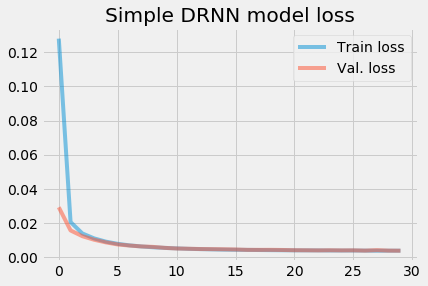

In [16]:
plt.plot(model_1.history.history['loss'], label = 'Train loss', alpha = .5)
plt.plot(model_1.history.history['val_loss'], label = 'Val. loss', alpha = .5)
plt.title('Simple DRNN model loss')
plt.legend()
plt.show()

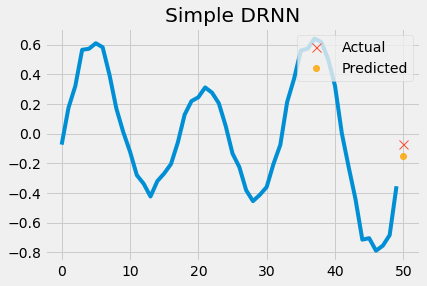

In [17]:
# Visualize the prediction
obs = 10
plt.plot(X_test[obs])
plt.plot(50, y_test[obs], 'x', markersize = 9, lw = 3, label = 'Actual')
plt.plot(50, model_1.predict(X_test[obs:obs + 1])[0][0], 'o', alpha = .8, color = 'orange', label = 'Predicted')
plt.legend(loc = 'upper right')
plt.title('Simple DRNN')
plt.show()

In [18]:
# Evaluate
model_1_preds = model_1.predict(X_test)
mse(model_1_preds.squeeze(), y_test.squeeze()).numpy()

0.00347884622509753

DRNN on 30 epochs was slightly better on test than the linear model: $MSE = 0.0035$

## Predict several timestep ahead one by one

Now, let's predict a couple of timesteps ahead. Let's start with the model we already have.

In [19]:
# 10 steps data
data_20 = get_data(1, n_steps + 20)     # Just one batch for now

In [132]:
X_20, y_20 = data_20[:, :n_steps], data_20[:, n_steps:]

In [133]:
X_20.shape, y_20.shape

((1, 50, 1), (1, 20, 1))

In [144]:
X = X_20

for step_ahead in range(20):
#     print(X[:, step_ahead:].shape)
    y_pred_local = model_1.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_local], axis = 1)

y_pred_20 = X[:, n_steps:]

In [152]:
X_20[:, :].shape

(1, 50, 1)

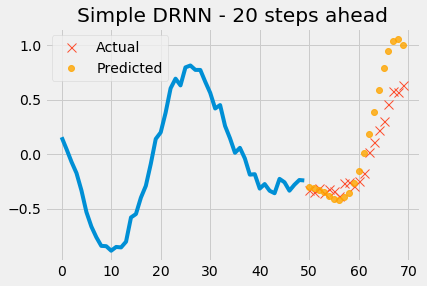

In [141]:
# Visualize the prediction
# obs = 10
plt.plot(X_20.squeeze())
plt.plot(np.arange(50, 70), y_20.squeeze(), 'x', markersize = 9, lw = 3, label = 'Actual')
plt.plot(np.arange(50, 70), y_pred_20.squeeze(), 'o', alpha = .8, color = 'orange', label = 'Predicted')
plt.legend(loc = 'upper left')
plt.title('Simple DRNN - 20 steps ahead')
plt.show()

## Predict several timesteps ahead using seq-to-seq RNN

In [2]:
# TBC...